# Bayesian Structural Time Series: Forecasting and Decomposition Using PyMC3

This is an advanced example of how a custom Bayesian time series forecasting/decomposition model can be built using PyMC3. The implementation is based on this [example](https://docs.pymc.io/notebooks/GP-MaunaLoa.html).

## Detailed Description
Please see blog post [D006](https://github.com/ikatsov/tensor-house/blob/master/resources/descriptions.md) for more details. 

## Data
The notebook uses datasets that are availbale in the **tensor-house-data** repository.

---

Running on PyMC3 v3.8


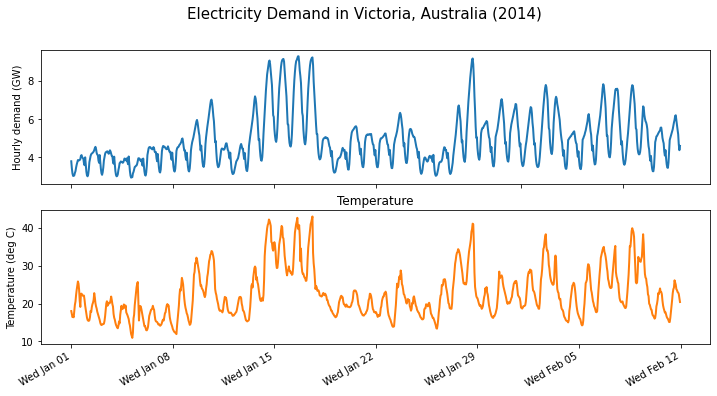

In [8]:
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import collections
import numpy as np
import pandas as pd

import pymc3 as pm
import arviz as az
print('Running on PyMC3 v{}'.format(pm.__version__))

demand_dates = np.arange('2014-01-01', '2014-02-26', dtype='datetime64[h]')
demand_loc = mdates.WeekdayLocator(byweekday=mdates.WE)
demand_fmt = mdates.DateFormatter('%a %b %d')

data = pd.read_csv('../resources/time-series/electricity-demand-victoria.csv', comment='#', header=None).T
data = pd.concat([data, pd.DataFrame(demand_dates)], axis=1)
data.columns = ["demand", "temperature", "date"]

num_forecast_steps = 24 * 7 * 2 # two weeks
data_training = data[:-num_forecast_steps]
data_test = data[-num_forecast_steps:]

colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(data_training.date,
        data_training.demand, lw=2, label="training data")
ax.set_ylabel("Hourly demand (GW)")

ax = fig.add_subplot(2, 1, 2)

ax.plot(data_training.date,
        data_training.temperature, lw=2, label="training data", c=c2)
ax.set_ylabel("Temperature (deg C)")
ax.set_title("Temperature")
ax.xaxis.set_major_locator(demand_loc)
ax.xaxis.set_major_formatter(demand_fmt)
fig.suptitle("Electricity Demand in Victoria, Australia (2014)", fontsize=15)
fig.autofmt_xdate()

In [2]:
#
# plotting functions
#
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]

    axes_dict = collections.OrderedDict()
    num_components = len(component_means_dict)
    fig = plt.figure(figsize=(12, 2.5 * num_components))
    for i, component_name in enumerate(component_means_dict.keys()):
        component_mean = component_means_dict[component_name]
        component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
    fig.autofmt_xdate()
    fig.tight_layout()
    return fig, axes_dict

## Model Specification and Fitting

We use an additive Gaussian processes model with a sum of three GPs for the signal, and one GP for the noise:
$$
f(t) \sim \mathcal{GP}_{\text{slow}}(0,\, k_1(t, t')) +
          \mathcal{GP}_{\text{med}}(0,\,  k_2(t, t')) +
          \mathcal{GP}_{\text{per}}(0,\,  k_3(t, t')) +
          \mathcal{GP}_{\text{noise}}(0,\,  k_n(t, t'))
$$

* A long term smooth rising trend represented by an exponentiated quadratic kernel.
* A periodic term that decays away from exact periodicity. This is represented by the product of a Periodic covariance function and an exponentiated quadratic.
* Small and medium term irregularities with a rational quadratic kernel.
* The noise is modeled as the sum of an Exponential and a white noise kernel

Lengthscale priors:
* ℓ_pdecay: The periodic decay. The smaller this parameter is, the faster the periodicity goes away.
* ℓ_psmooth: The smoothness of the periodic component. It controls how “sinusoidal” the periodicity is.
* period: The period. We put a strong prior on a period of one day.
* ℓ_med: This is the lengthscale for the short to medium long variations.
* α: This is the shape parameter.
* ℓ_trend: The lengthscale of the long term trend.
* ℓ_noise: The lengthscale of the noise covariance.

Scale priors:
* η_per: Scale of the periodic or seasonal component.
* η_med: Scale of the short to medium term component.
* η_trend: Scale of the long term trend.
* σ: Scale of the white noise.
* η_noise: Scale of correlated, short term noise.

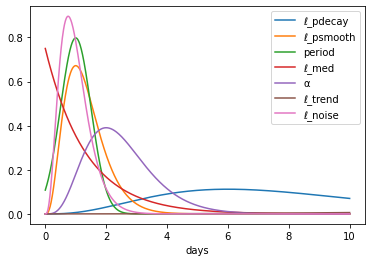

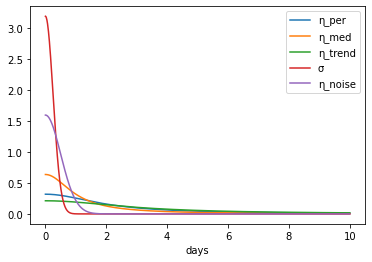

In [25]:
#
# plot the priors
#
x = np.linspace(0, 10, 1000)
priors = [
    ("ℓ_pdecay",  pm.Gamma.dist(alpha=4,  beta=0.5)),
    ("ℓ_psmooth", pm.Gamma.dist(alpha=4,  beta=3)),
    ("period",    pm.Normal.dist(mu=1,  sigma=0.5)),
    ("ℓ_med",     pm.Gamma.dist(alpha=1,  beta=0.75)),
    ("α",         pm.Gamma.dist(alpha=5,  beta=2)),
    ("ℓ_trend",   pm.Gamma.dist(alpha=4,  beta=0.1)),
    ("ℓ_noise",   pm.Gamma.dist(alpha=4,  beta=4))]

for i, prior in enumerate(priors):
    plt.plot(x, np.exp(prior[1].logp(x).eval()), label=prior[0])
plt.legend(loc="upper right")
plt.xlabel("days")
plt.show();

x = np.linspace(0, 10, 1000)
priors = [
    ("η_per",   pm.HalfCauchy.dist(beta=2)),
    ("η_med",   pm.HalfCauchy.dist(beta=1.0)),
    ("η_trend", pm.HalfCauchy.dist(beta=3)), 
    ("σ",       pm.HalfNormal.dist(sigma=0.25)),
    ("η_noise", pm.HalfNormal.dist(sigma=0.5))]

for i, prior in enumerate(priors):
    plt.plot(x, np.exp(prior[1].logp(x).eval()), label=prior[0])
plt.legend(loc="upper right")
plt.xlabel("days")
plt.show();

In [27]:
def dates_to_idx(timelist):
    reference_time = pd.to_datetime('2014-01-01')
    t = (timelist - reference_time) / pd.Timedelta(1, "D")
    return np.asarray(t)

t = dates_to_idx(data_training.date)[:,None]
y = data_training.demand.values

#
# define and fit the model
#
with pm.Model() as model:
    # daily periodic component x long term trend
    η_per = pm.HalfCauchy("η_per", beta=2, testval=1.0)
    ℓ_pdecay = pm.Gamma("ℓ_pdecay", alpha=4, beta=0.5)
    period  = pm.Normal("period", mu=1, sigma=0.5)
    ℓ_psmooth = pm.Gamma("ℓ_psmooth ", alpha=4, beta=3)
    cov_seasonal = η_per**2 * pm.gp.cov.Periodic(1, period, ℓ_psmooth) \
                            * pm.gp.cov.Matern52(1, ℓ_pdecay)
    gp_seasonal = pm.gp.Marginal(cov_func=cov_seasonal)

    # small/medium term irregularities
    η_med = pm.HalfCauchy("η_med", beta=0.5, testval=0.1)
    ℓ_med = pm.Gamma("ℓ_med", alpha=2, beta=0.75)
    α = pm.Gamma("α", alpha=5, beta=2)
    cov_medium = η_med**2 * pm.gp.cov.RatQuad(1, ℓ_med, α)
    gp_medium = pm.gp.Marginal(cov_func=cov_medium)

    # long term trend
    η_trend = pm.HalfCauchy("η_trend", beta=2, testval=2.0)
    ℓ_trend = pm.Gamma("ℓ_trend", alpha=4, beta=0.1)
    cov_trend = η_trend**2 * pm.gp.cov.ExpQuad(1, ℓ_trend)
    gp_trend = pm.gp.Marginal(cov_func=cov_trend)

    # noise model
    η_noise = pm.HalfNormal("η_noise", sigma=0.5, testval=0.05)
    ℓ_noise = pm.Gamma("ℓ_noise", alpha=4, beta=4)
    σ  = pm.HalfNormal("σ",  sigma=0.25, testval=0.05)
    cov_noise = η_noise**2 * pm.gp.cov.Matern32(1, ℓ_noise) + pm.gp.cov.WhiteNoise(σ)

    # The Gaussian process is a sum of these three components
    gp = gp_seasonal + gp_medium + gp_trend

    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    y_ = gp.marginal_likelihood("y", X=t, y=y, noise=cov_noise)

    # this line calls an optimizer to find the MAP
    mp = pm.find_MAP(include_transformed=True)
    
# fitted model parameters
sorted([name + ":" + str(mp[name]) for name in mp.keys() if not name.endswith("_")])

logp = 1,015.8, ||grad|| = 11.708: 100%|██████████| 319/319 [03:16<00:00,  1.63it/s]    


['period:0.999960685294285',
 'α:2.3469484827864417',
 'η_med:0.09305963018426591',
 'η_noise:1.0753587806014806',
 'η_per:0.4816629378822683',
 'η_trend:3.154272052333219',
 'σ:0.0008251626417600294',
 'ℓ_med:1.6068695952914671',
 'ℓ_noise:0.5276940842006947',
 'ℓ_pdecay:61.57976585887905',
 'ℓ_psmooth :0.18132031275494137',
 'ℓ_trend:62.945918039691435']

## Forecasting

Sampling gp predictions...


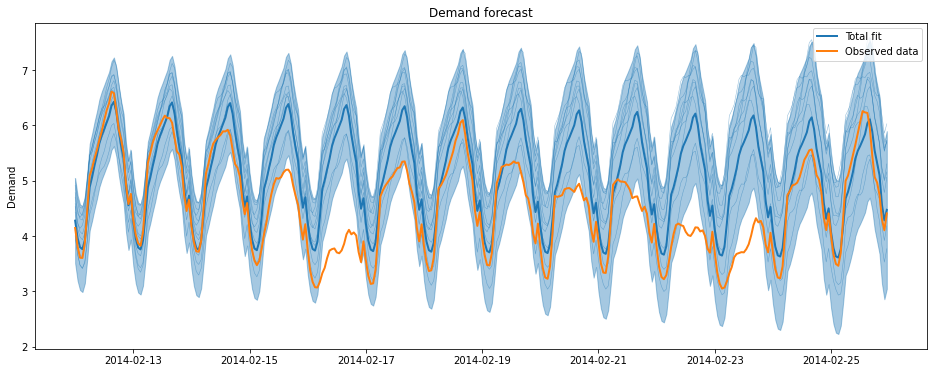

In [28]:
dates = pd.date_range(start='2014-02-12', end="2014-02-26", freq="1H")[:-1]
tnew = dates_to_idx(dates)[:,None]
first_y = 0
std_y = 1

print("Sampling gp predictions...")
mu_pred, cov_pred = gp.predict(tnew, point=mp)

# draw samples, and rescale
n_samples = 2000
samples = pm.MvNormal.dist(mu=mu_pred, cov=cov_pred).random(size=n_samples)
samples = samples * std_y + first_y

### plot mean and 2σ region of total prediction
fig = plt.figure(figsize=(16, 6))

# scale mean and var
mu_pred_sc = mu_pred * std_y + first_y
sd_pred_sc = np.sqrt(np.diag(cov_pred) * std_y**2 )
upper = mu_pred_sc + 2*sd_pred_sc
lower = mu_pred_sc - 2*sd_pred_sc

c = sns.color_palette()
plt.plot(data_test.date, mu_pred_sc, linewidth=2, color=c[0], label="Total fit")
plt.fill_between(data_test.date, lower, upper, color=c[0], alpha=0.4)

# some predictions
idx = np.random.randint(0, samples.shape[0], 10)
for i in idx:
    plt.plot(data_test.date, samples[i,:], color=c[0], alpha=0.5, linewidth=0.5)

# true value
plt.plot(data_test.date, data_test.demand, linewidth=2, color=c[1], label="Observed data")

plt.ylabel("Demand")
plt.title("Demand forecast")
plt.legend(loc="upper right")
plt.show();

## Decomposition

Predicting with gp ...
Predicting with gp_trend ...
Predicting with gp_medium ...
Predicting with gp_seasonal ...


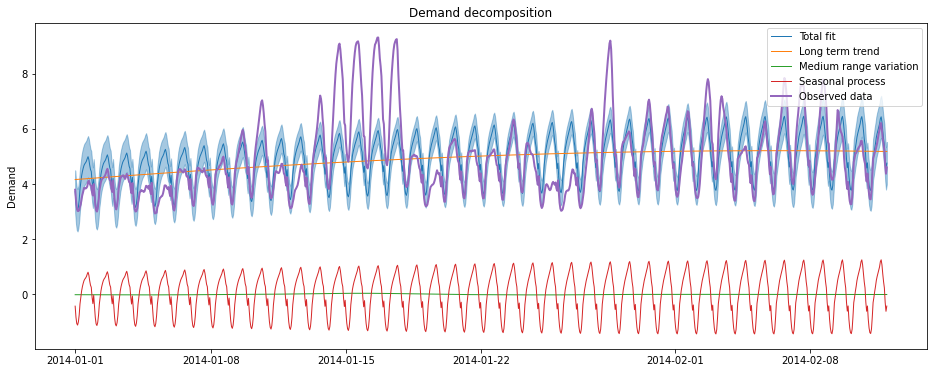

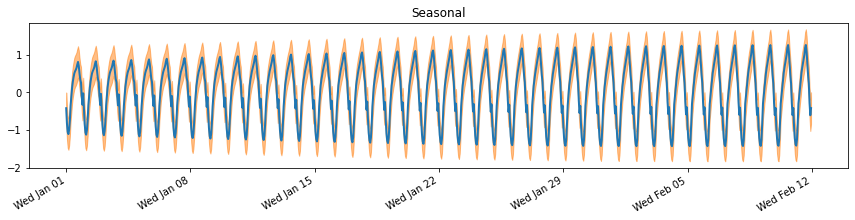

In [29]:
# predict at a 1 hour granularity
dates = pd.date_range(start='2014-01-01', end="2014-02-12", freq="1H")[:-1]
tnew = dates_to_idx(dates)[:,None]

print("Predicting with gp ...")
mu, var = gp.predict(tnew, point=mp, diag=True)
mean_pred = mu*std_y + first_y
var_pred  = var*std_y**2

# make dataframe to store fit results
fit = pd.DataFrame({"t": tnew.flatten(),
                    "mu_total": mean_pred,
                    "sd_total": np.sqrt(var_pred)},
                   index=dates)

print("Predicting with gp_trend ...")
mu, var = gp_trend.predict(tnew, point=mp,
                           given={"gp": gp, "X": t, "y": y, "noise": cov_noise},
                           diag=True)
fit = fit.assign(mu_trend = mu*std_y + first_y,
                 sd_trend = np.sqrt(var*std_y**2))

print("Predicting with gp_medium ...")
mu, var = gp_medium.predict(tnew, point=mp,
                            given={"gp": gp, "X": t, "y": y, "noise": cov_noise},
                            diag=True)
fit = fit.assign(mu_medium = mu*std_y + first_y,
                 sd_medium = np.sqrt(var*std_y**2))

print("Predicting with gp_seasonal ...")
mu, var = gp_seasonal.predict(tnew, point=mp,
                              given={"gp": gp, "X": t, "y": y, "noise": cov_noise},
                              diag=True)
fit = fit.assign(mu_seasonal = mu*std_y + first_y,
                 sd_seasonal = np.sqrt(var*std_y**2))

## plot the decompostion
fig = plt.figure(figsize=(16, 6))

# plot mean and 2σ region of total prediction
upper = fit.mu_total + 2*fit.sd_total
lower = fit.mu_total - 2*fit.sd_total
band_x = np.append(fit.index.values, fit.index.values[::-1])
band_y = np.append(lower, upper[::-1])

c = sns.color_palette()

# total fit
plt.plot(fit.index, fit.mu_total, linewidth=1, color=c[0], label="Total fit")
plt.fill_between(fit.index, lower, upper, color=c[0], alpha=0.4)

# trend
plt.plot(fit.index, fit.mu_trend, linewidth=1, color=c[1], label="Long term trend")

# medium
plt.plot(fit.index, fit.mu_medium, linewidth=1, color=c[2], label="Medium range variation")

# seasonal
plt.plot(fit.index, fit.mu_seasonal, linewidth=1, color=c[3], label="Seasonal process")

# true value
plt.plot(data_training.date, data_training.demand, linewidth=2, color=c[4], label="Observed data")

plt.ylabel("Demand")
plt.title("Demand decomposition")
plt.legend(loc="upper right")
plt.show();

#
# plot separate components of the decomposition 
#
demand_component_means = {
    'Ground truth': data_training.demand,
    'Total fit': fit.mu_total,
    'Trend': fit.mu_trend,
    'Medium': fit.mu_medium,
    'Seasonal': fit.mu_seasonal,
}
demand_component_stddevs = {
    'Ground truth': np.zeros(len(data_training.demand)),
    'Total fit': fit.sd_total,
    'Trend': fit.sd_trend,
    'Medium': fit.sd_medium,
    'Seasonal': fit.sd_seasonal,
}

fig, axes = plot_components(
  data_training.date,
  demand_component_means,
  demand_component_stddevs,
  x_locator=demand_loc, x_formatter=demand_fmt)